In [ ]:
!apt-get -y install fonts-nanum
!fc-cache -fv
!rm -rf ~/.cache/matplotlib

In [ ]:
!pip install xgboost lightgbm matplotlib scikit-learn

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 데이터 다운로드
!gdown 1G7K6jL3MiZl9-Bnz9ux-20CQ2DjZ0y_L

## 모델링 전 EDA
- 폐업률(종속변수): 클래스 불균형 처리 필요
  - 0이상이면 폐업(1), 아니면 영업중(0)
  - 폐업이 소수 클래스  
- 총방문인구수, 총주거인구수, 총이용금액: 정규화 필요  

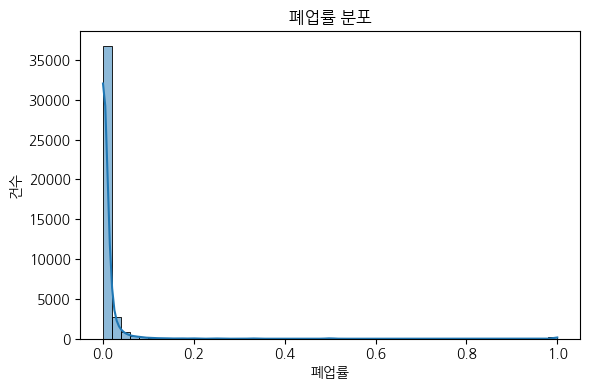

In [34]:
#  폐업률 분포 확인
df = pd.read_csv("final_analysis_v3_cleaned_full.csv", encoding="utf-8-sig")

plt.figure(figsize=(6, 4))
sns.histplot(df["폐업률"], bins=50, kde=True)
plt.title("폐업률 분포")
plt.xlabel("폐업률")
plt.ylabel("건수")
plt.tight_layout()
plt.show()

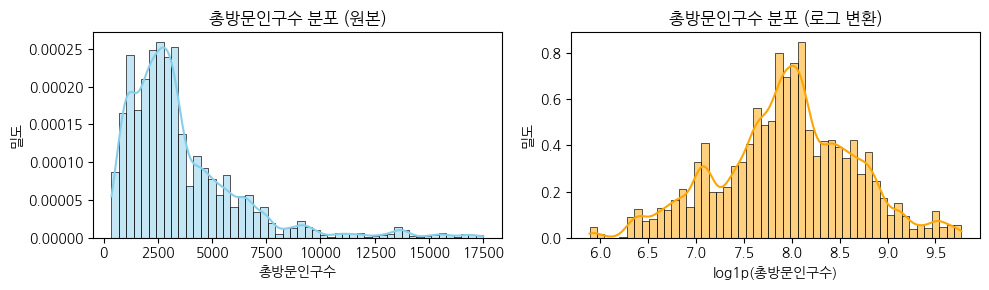

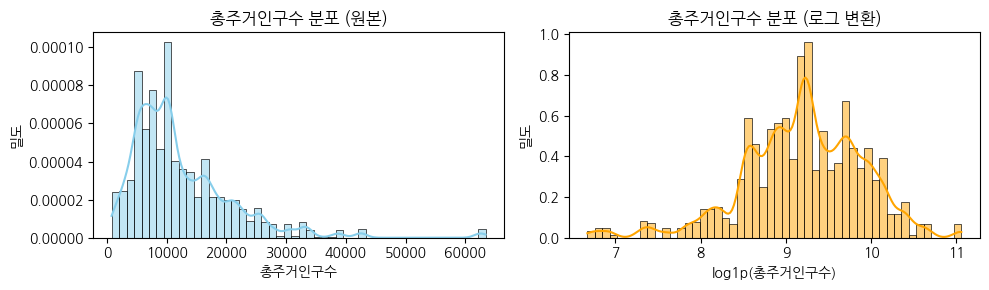

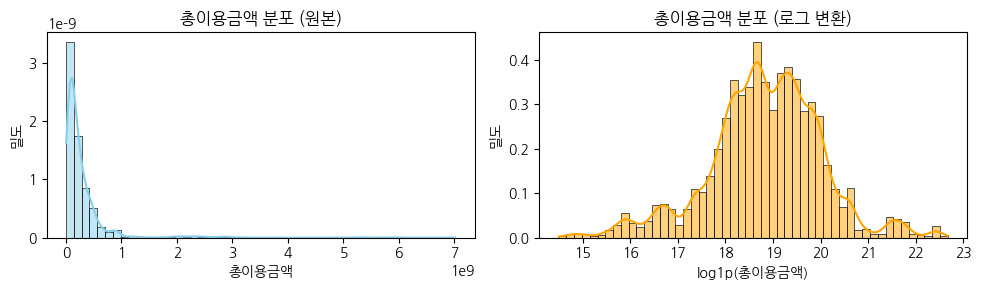

In [36]:
# 로그 변환 대상 컬럼 확인
log_cols = ['총방문인구수', '총주거인구수', '총이용금액']
for col in log_cols:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", ""), errors="coerce")
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    sns.histplot(df[col].dropna(), bins=50, color='skyblue', kde=True, stat="density", ax=axes[0])
    axes[0].set_title(f"{col} 분포 (원본)")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("밀도")

    log_transformed = np.log1p(df[col][df[col] >= 0].dropna())
    sns.histplot(log_transformed, bins=50, color='orange', kde=True, stat="density", ax=axes[1])
    axes[1].set_title(f"{col} 분포 (로그 변환)")
    axes[1].set_xlabel(f"log1p({col})")
    axes[1].set_ylabel("밀도")

    plt.tight_layout()
    plt.show()

## 기본 전처리

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# 라벨 인코딩
for col in ["대분류명", "행정동", "시군구"]:
    df[col + "_인코딩"] = LabelEncoder().fit_transform(df[col])

# 수치형 변환
for col in ['지역화폐가맹률', '폐업률', '총방문인구수', '건당_평균_결제금액', '역세권점포비율', '총이용금액']:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", ""), errors="coerce")

# 로그 변환
for col in ['총방문인구수', '총주거인구수', '총이용금액']:
    df[col] = np.log1p(df[col])

# 파생 변수 생성
df['가맹률_이동평균'] = df.groupby(['시군구', '행정동'])['지역화폐가맹률'].transform(lambda x: x.rolling(3, min_periods=1).mean())
df['가맹률_추세'] = df['지역화폐가맹률'] - df['가맹률_이동평균']
df['월'] = pd.to_datetime(df['기준연월']).dt.month

# y값 정의 (폐업률이 0보다 크면 페업(1), 아니면 영업중(0))
df["폐업여부"] = (df["폐업률"] > 0).astype(int)

# X값 정의
features = [
    '지역화폐가맹률', '역세권점포비율', '월별_총거래건수', '월별_총거래금액', '건당_평균_결제금액',
    '총방문인구수', '총주거인구수', '남성비율_방문', '여성비율_방문', '남성비율_주거', '여성비율_주거',
    '20대미만_비율', '20대_비율', '30대_비율', '40대_비율', '50대_비율', '60대_비율', '70대이상_비율',
    '총이용금액', '새벽_소비비율', '아침_소비비율', '낮_소비비율', '저녁_소비비율', '밤_소비비율',
    '대분류명_인코딩', '행정동_인코딩', '시군구_인코딩', '가맹률_추세'
]

In [38]:
# 상관계수 계산
corr_df = df[features + ["폐업여부"]].corr()
corr_with_target = corr_df["폐업여부"].drop("폐업여부").sort_values(ascending=False)

print(f"폐업여부와 피처 간 상관계수: \n{corr_with_target}")

폐업여부와 피처 간 상관계수: 
월별_총거래건수      0.219819
월별_총거래금액      0.213799
지역화폐가맹률       0.170245
총이용금액         0.123144
총방문인구수        0.117909
대분류명_인코딩      0.103121
건당_평균_결제금액    0.101262
총주거인구수        0.098702
20대_비율        0.080605
30대_비율        0.065979
저녁_소비비율       0.044853
가맹률_추세        0.038508
여성비율_방문       0.029455
밤_소비비율        0.024160
여성비율_주거       0.021141
20대미만_비율      0.020586
행정동_인코딩       0.017510
시군구_인코딩       0.017131
역세권점포비율       0.016064
40대_비율        0.002019
새벽_소비비율      -0.012475
낮_소비비율       -0.013205
남성비율_주거      -0.021141
남성비율_방문      -0.029455
아침_소비비율      -0.067104
50대_비율       -0.071953
70대이상_비율     -0.077508
60대_비율       -0.088814
Name: 폐업여부, dtype: float64


In [39]:
# vif 계산
# 트리기반 모델은 다중공선성에 비교적 강하지만 해석 측면에서 정확한 변수 선정을 위함
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_corr = df[features].fillna(0)

# VIF 계산
vif_df = pd.DataFrame()
vif_df["feature"] = X_corr.columns
vif_df["VIF"] = [variance_inflation_factor(X_corr.values, i) for i in range(X_corr.shape[1])]

vif_df.sort_values("VIF", ascending=False)

,feature,VIF
9,남성비율_주거,4.503600e+15
7,남성비율_방문,2.251800e+15
8,여성비율_방문,1.801440e+15
10,여성비율_주거,3.464307e+14
21,낮_소비비율,1.609767e+06
22,저녁_소비비율,8.511194e+05
12,20대_비율,4.174242e+05
23,밤_소비비율,2.569000e+05
11,20대미만_비율,2.457036e+05
20,아침_소비비율,2.455918e+05


- VIF가 10 이상: 매우 심각한 다중공선성, 제거 고려
- VIF = inf: 다른 변수와 완전한 선형관계,	반드시 제거 필요
- VIF = 5~10:	다중공선성 있음,	해석 필요

## feature selection  

In [40]:
# VIF 10 이상인 변수 확인
high_vif = vif_df[vif_df["VIF"] > 10]
print(high_vif)

     feature           VIF
2   월별_총거래건수  1.021874e+01
3   월별_총거래금액  1.041640e+01
7    남성비율_방문  2.251800e+15
8    여성비율_방문  1.801440e+15
9    남성비율_주거  4.503600e+15
10   여성비율_주거  3.464307e+14
11  20대미만_비율  2.457036e+05
12    20대_비율  4.174242e+05
13    30대_비율  8.919978e+04
14    40대_비율  7.714378e+04
15    50대_비율  9.777867e+04
16    60대_비율  1.405541e+05
17  70대이상_비율  1.191044e+05
19   새벽_소비비율  8.422284e+04
20   아침_소비비율  2.455918e+05
21    낮_소비비율  1.609767e+06
22   저녁_소비비율  8.511194e+05
23    밤_소비비율  2.569000e+05


In [43]:
#  Mutual Information 기반 변수 선택
from sklearn.feature_selection import mutual_info_classif

# X, y 정의
X = df[features].fillna(0)
y = df["폐업여부"]

# Mutual Information 계산
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_df = pd.DataFrame({'feature': X.columns, 'mutual_info': mi_scores})
mi_df = mi_df.sort_values(by='mutual_info', ascending=False)

print("Mutual Information 기준 피처 중요도:")
print(mi_df)

Mutual Information 기준 피처 중요도:
       feature  mutual_info
24    대분류명_인코딩     0.139769
0      지역화폐가맹률     0.103353
3     월별_총거래금액     0.088795
2     월별_총거래건수     0.087515
4   건당_평균_결제금액     0.078176
1      역세권점포비율     0.066787
27      가맹률_추세     0.054935
25     행정동_인코딩     0.016605
22     저녁_소비비율     0.006381
26     시군구_인코딩     0.005959
13      30대_비율     0.005090
12      20대_비율     0.004762
20     아침_소비비율     0.004394
16      60대_비율     0.004219
15      50대_비율     0.004118
6       총주거인구수     0.004016
21      낮_소비비율     0.003871
17    70대이상_비율     0.003430
11    20대미만_비율     0.003032
23      밤_소비비율     0.002922
18       총이용금액     0.002587
5       총방문인구수     0.002290
8      여성비율_방문     0.002151
10     여성비율_주거     0.002070
9      남성비율_주거     0.002042
7      남성비율_방문     0.001585
19     새벽_소비비율     0.000479
14      40대_비율     0.000000


In [46]:
# 그룹별로 가장 높은 mutual_info 값을 가진 변수 선택
# 성별 방문/주거
gender_group = ["남성비율_방문", "여성비율_방문", "남성비율_주거", "여성비율_주거"]
top_gender = mi_df[mi_df["feature"].isin(gender_group)].sort_values("mutual_info", ascending=False).iloc[0]["feature"]

# 소비 시간대
time_group = ["새벽_소비비율", "아침_소비비율", "낮_소비비율", "저녁_소비비율", "밤_소비비율"]
top_time = mi_df[mi_df["feature"].isin(time_group)].sort_values("mutual_info", ascending=False).iloc[0]["feature"]

# 연령대
age_group = ["20대미만_비율", "20대_비율", "30대_비율", "40대_비율", "50대_비율", "60대_비율", "70대이상_비율"]
top_age = mi_df[mi_df["feature"].isin(age_group)].sort_values("mutual_info", ascending=False).iloc[0]["feature"]

# 월별 거래 변수
trade_group = ["월별_총거래건수", "월별_총거래금액"]
top_trade = mi_df[mi_df["feature"].isin(trade_group)].sort_values("mutual_info", ascending=False).iloc[0]["feature"]

# 최종 선택된 변수
selected_features = [top_gender, top_time, top_age, top_trade]
print("Mutual Info 기반 대표 피처 선택 결과:")
print(f"성별 관련 대표 변수: {top_gender}")
print(f"소비 시간대 대표 변수: {top_time}")
print(f"연령대 대표 변수: {top_age}")
print(f"거래 관련 대표 변수: {top_trade}")

# 나머지 피처 정의
additional_features = [
    '지역화폐가맹률', '총방문인구수', '총이용금액', '건당_평균_결제금액',
    '대분류명_인코딩', '시군구_인코딩', '행정동_인코딩', '가맹률_추세', '총주거인구수', '역세권점포비율'
]

# 최종 피처 리스트 확인
final_features = selected_features + additional_features
print("\n최종 모델에 사용할 피처 리스트:")
print(final_features)

Mutual Info 기반 대표 피처 선택 결과:
성별 관련 대표 변수: 여성비율_방문
소비 시간대 대표 변수: 저녁_소비비율
연령대 대표 변수: 30대_비율
거래 관련 대표 변수: 월별_총거래금액

최종 모델에 사용할 피처 리스트:
['여성비율_방문', '저녁_소비비율', '30대_비율', '월별_총거래금액', '지역화폐가맹률', '총방문인구수', '총이용금액', '건당_평균_결제금액', '대분류명_인코딩', '시군구_인코딩', '행정동_인코딩', '가맹률_추세', '총주거인구수', '역세권점포비율']


## 모델링
- randomforest, xgboost, lgbm 적용 결과, xgboost의 성능이 우수  

In [ ]:
# train/test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

X_train = train_df[final_features].fillna(0).astype(np.float32)
y_train = train_df["폐업여부"].values
X_test = test_df[final_features].fillna(0).astype(np.float32)
y_test = test_df["폐업여부"].values

# 클래스 불균형 처리 방법: class_weight
models = {
    "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=42, scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
    "LightGBM": LGBMClassifier(random_state=42, class_weight='balanced')
}

results = {}

for name, model in models.items():
    print(f"\n 모델: {name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, probs)
    print("ROC-AUC:", round(auc, 4))
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds, digits=4))

    results[name] = {
        "model": model,
        "roc_auc": auc,
    }

In [49]:
# pr 커브 계산 (클래스 불균형 데이터에 적합한 평가 지표)

from sklearn.metrics import average_precision_score

for name, result in results.items():
    model = result["model"]
    probs = model.predict_proba(X_test)[:, 1]
    pr_auc = average_precision_score(y_test, probs)
    results[name]["pr_auc"] = pr_auc
    print(f"{name} PR AUC: {pr_auc:.4f}")

RandomForest PR AUC: 0.6870
XGBoost PR AUC: 0.6920
LightGBM PR AUC: 0.6888


## 모델 성능 비교  

| 모델           | 폐업 Recall | 폐업 Precision | 폐업 F1-score | PR-AUC | ROC-AUC |
| ------------ | --------- | ------------ | ------------- | ------ | ------- |
| RandomForest | 0.5331    | 0.6727       | 0.5955        | 0.6859 | 0.8811  |
| XGBoost      | 0.8202    | 0.5543       | 0.6616        | 0.6920 | 0.8851  |
| LightGBM     | 0.8567    | 0.5239       | 0.6508        | 0.6886 | 0.8851  |


-> 최종 모델 선정: XGBoost  
- 선정 기준: 폐업 위험 점포를 놓치지 않고 탐지할 수 있는 모델  
  - **Recall**이 높을수록 → 폐업 점포를 놓치지 않고 탐지
  - **F1-score**가 높을수록 → 폐업 탐지율과 정상 점포 구분 능력 균형 우수
  - **PR-AUC**가 높을수록 → 불균형 데이터에서 폐업 점포 탐지 성능 우수
- XGBoost가 precision, f1-score, pr-auc에서 우수한 성능을 보여 최종 모델로 선정함  

In [ ]:
!pip install optuna

In [66]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost.callback import EarlyStopping

def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "scale_pos_weight": (y_train == 0).sum() / (y_train == 1).sum(),
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "logloss"
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    aucs = []

    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train[train_idx], y_train[valid_idx]

        model = XGBClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

        preds = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, preds)
        aucs.append(auc)

    return np.mean(aucs)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best AUC:", study.best_value)
print("Best hyperparameters:", study.best_trial.params)


[I 2025-07-26 20:23:56,976] A new study created in memory with name: no-name-86590ee8-ba2e-4bb1-aee8-45ea9eb2670a
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:23:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:24:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [20:24:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-07-26 20:24:03,669] Trial 0 finished with value: 0.8823405718334181 and parameters: {'max_depth': 6, 'learning_rate': 0.08448304730325105, 'n_estimators': 351, 'subsample': 0.6343323279229646, 'colsample

Best AUC: 0.888100678372142
Best hyperparameters: {'max_depth': 9, 'learning_rate': 0.012418963681998928, 'n_estimators': 851, 'subsample': 0.9423820835686505, 'colsample_bytree': 0.9333937912368272}


In [ ]:
# 최적 파라미터로 학습
best_params = study.best_trial.params
best_params.update({
    "scale_pos_weight": (y_train == 0).sum() / (y_train == 1).sum(),
    "random_state": 42,
    "use_label_encoder": False,
    "eval_metric": "logloss"
})

final_model = XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

# 예측 및 지표 계산
y_pred_prob = final_model.predict_proba(X_test)[:, 1]
y_pred = final_model.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
recall = report["1"]["recall"]
f1 = report["1"]["f1-score"]
precision = report["1"]["precision"]
pr_auc = average_precision_score(y_test, y_pred_prob)
roc = roc_auc_score(y_test, y_pred_prob)

result_df = pd.DataFrame([{
    "모델": "XGBoost 최종",
    "폐업 Recall": recall,
    "F1-score": f1,
    "Precision": precision,
    "PR-AUC": pr_auc,
    "ROC-AUC": roc
}])
print(result_df)

In [69]:
# 모델 저장
import joblib

joblib.dump(final_model, "xgb_final_model.pkl")

['xgb_final_model.pkl']

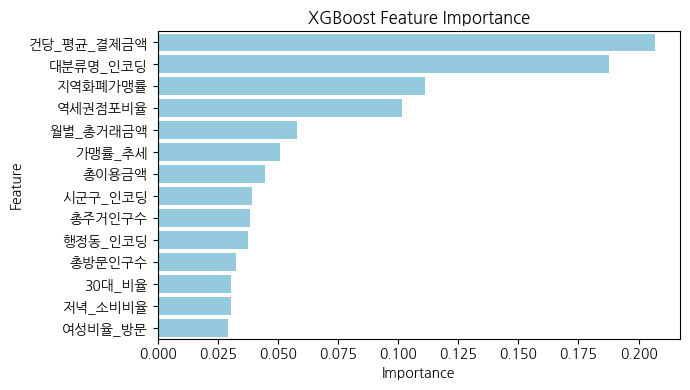

In [70]:
# 최종 튜닝된 모델으로 피처 중요도 확인
xgb_model = final_model

feature_importances = xgb_model.feature_importances_
feature_names = final_features

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(7, 4))
sns.barplot(data=feature_importance_df, x="Importance", y="Feature", color="skyblue")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

In [71]:
feature_importance_df

,Feature,Importance
7,건당_평균_결제금액,0.206909
8,대분류명_인코딩,0.187903
4,지역화폐가맹률,0.111258
13,역세권점포비율,0.101542
3,월별_총거래금액,0.057880
11,가맹률_추세,0.051050
6,총이용금액,0.044711
9,시군구_인코딩,0.039206
12,총주거인구수,0.038434
10,행정동_인코딩,0.037792


- 정량적 소비력(건당 결제금액)이 폐업여부에 가장 중요.
- 업종(대분류명)도 강한 영향을 줌.
- 입지 특성(역세권점포비율, 지역화폐가맹률)도 중요.
- 성별/연령/시간대 비율은 모델에 영향은 주지만 비중은 낮음.